In [1]:
import pandas as pd
import numpy as np

In [2]:
#path = '/content/mlb_dp3.xlsx'
path = '/content/mlb_rawdata.xlsx'

In [3]:
df = pd.read_excel(path)

In [4]:
# pitcher 이름 재조정
df["pitcher"] = df["pitcher"].apply(lambda x: " ".join(x.split(", ")[::-1]))

In [5]:
pitcher_hand = pd.read_excel(r"/content/pitcher_hand.xlsx")

In [6]:
pitcher_hand.head()

,name,player_id,hand
0,Edward Cabrera,665795,R
1,Gerrit Cole,543037,R
2,Erick Fedde,607200,R
3,Jameson Taillon,592791,R
4,Tejay Antone,622088,R


In [7]:
batter_hand = pd.read_excel(r"/content/batter_hand.xlsx")

In [8]:
batter_hand.head()

,name,player_id,hand
0,Jonny DeLuca,676356,R
1,Elias Díaz,553869,R
2,Byron Buxton,621439,R
3,Jarren Duran,680776,L
4,Kameron Misner,670224,L


In [9]:
df.dropna(axis=0, inplace=True)

In [10]:
# 타구 종류 숫자화
# c2c2c2 : field out = 0
# FE6100 : single (1루타) = 1
# 785EF0 : double (2루타) = 2
# FFB000 : triple (3루타) = 3
# DC267F : homerun (홈런) = 4
# 999900 : error = 5
# cc6600 : sacrifice = 6
# mapping = {
#     '#c2c2c2': 0,  # fieldout
#     '#FE6100': 1,  # single
#     '#785EF0': 2,  # double
#     '#FFB000': 3,  # triple
#     '#DC267F': 4,  # homerun
#     '#999900': 5,  # error
#     '#cc6600': 6   # sacrifice
# }

# mapping = {
#     '#c2c2c2': "fieldout",
#     '#FE6100': "single",
#     '#785EF0': "double",
#     '#FFB000': "triple",
#     '#DC267F': "homerun",
#     '#999900': "error",
#     '#cc6600': "sacrifice"
# }

# df['ball_type'] = df['ball_type'].replace(mapping)

# pitcher_hand 추가
merged_df = pd.merge(df, pitcher_hand[['name', 'hand']], left_on='pitcher', right_on="name", how='left')
df['pitcher_hand'] = merged_df['hand']
df['pitcher_hand'] = df['pitcher_hand'].replace({'R': 0, 'L': 1})

# batter_hand 추가
b_merged_df = pd.merge(df, batter_hand[['name', 'hand']], left_on='name', right_on="name", how='left')
df['batter_hand'] = b_merged_df['hand']
df.loc[(df['batter_hand'] == 'S') & (df['pitcher_hand'] == 'R'), 'batter_hand'] = 'L'
df.loc[(df['batter_hand'] == 'S') & (df['pitcher_hand'] == 'L'), 'batter_hand'] = 'R'
df['batter_hand'] = df['batter_hand'].replace({'R': 0, 'L': 1})

mask = (df['batter_hand'] == 'S') & (df['pitcher_hand'] == 'R')
df.loc[mask, 'batter_hand'] = 'L'
mask2 = (df['batter_hand'] == 'S') & (df['pitcher_hand'] == 'L')
df.loc[mask2, 'batter_hand'] = 'R'

<ipython-input-10-fd31c201134f>:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['pitcher_hand'] = df['pitcher_hand'].replace({'R': 0, 'L': 1})


In [11]:
df["batter_hand"].value_counts()

,count
batter_hand,
0,343
1,202
S,60


In [12]:
# 볼카운트
# count 열을 분리하여 새로운 열(ball, strike) 생성
df[['ball', 'strike']] = df['count'].str.split(' - ', expand=True)
# ball과 strike 열을 숫자로 변환
df['ball'] = df['ball'].astype(int)
df['strike'] = df['strike'].astype(int)

# 구종 (pitch_type) 숫자화
pitch_mapping = {
    'FF': 0,
    'SI': 1,
    'SL': 2,
    'CH': 3,
    'FC': 4,
    'ST': 5,
    'CU': 6,
    'FS': 7,
    'KC': 8,
    'SV': 9,
    'EP': 10,
    'KN': 11,
    'FA': 12,
    'FO': 13,
    'SC': 14,
    'CS': 15
}

# pitch_type 열을 매핑하여 숫자화
df['pitch_type'] = df['pitch_type'].replace(pitch_mapping)


<ipython-input-12-27fe7b044c77>:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['pitch_type'] = df['pitch_type'].replace(pitch_mapping)


In [13]:
df.head()

,id,name,year,cx,cy,ball_type,batter,pitcher,count,pitch_type,...,exit_velocity,hr,matchup,date,zone_num,hit_dist,pitcher_hand,batter_hand,ball,strike
11,676356,Jonny DeLuca,2024,106.720244,97.808537,#DC267F,"DeLuca, Jonny",Jared Shuster,1 - 1,3,...,105.2,29/30 parks,CWS @ TB,2024-05-06,7,401,0.0,0,1,1
33,676356,Jonny DeLuca,2024,70.421707,161.930244,#DC267F,"DeLuca, Jonny",Dylan Lee,2 - 1,0,...,95.4,20/30 parks,TB @ ATL,2024-06-14,2,360,0.0,0,2,1
53,676356,Jonny DeLuca,2024,79.838780,147.719024,#c2c2c2,"DeLuca, Jonny",Albert Suárez,0 - 1,4,...,100.1,14/30 parks,TB @ BAL,2024-05-31,12,364,0.0,0,0,1
57,676356,Jonny DeLuca,2024,209.195122,67.588293,#c2c2c2,"DeLuca, Jonny",Cole Irvin,0 - 1,4,...,100.9,11/30 parks,TB @ BAL,2024-06-02,7,400,0.0,1,0,1
70,676356,Jonny DeLuca,2024,66.483659,161.416585,#c2c2c2,"DeLuca, Jonny",Dylan Lee,2 - 1,0,...,95.4,20/30 parks,TB @ ATL,2024-06-14,2,360,1.0,0,2,1


In [14]:
df.columns.tolist()

['id',
 'name',
 'year',
 'cx',
 'cy',
 'ball_type',
 'batter',
 'pitcher',
 'count',
 'pitch_type',
 'velocity',
 'exit_velocity',
 'hr',
 'matchup',
 'date',
 'zone_num',
 'hit_dist',
 'pitcher_hand',
 'batter_hand',
 'ball',
 'strike']

In [20]:
df = df.drop(['year'], axis=1)

KeyError: "['year'] not found in axis"

In [21]:
df = df.drop(['wind_ms'], axis=1)

KeyError: "['wind_ms'] not found in axis"

In [ ]:
df = df.drop(['rain'], axis=1)

In [ ]:
df.head()

,Unnamed: 0,id,name,cx,cy,ball_type,pitcher,pitch_type,velocity,exit_velocity,...,date,zone_num,pitcher_hand,batter_hand,ball,strike,place,temp,wind,category_rain
0,0,676356,Jonny DeLuca,210.821707,317.140732,fieldout,Emmanuel Clase,2,91.2,88.5,...,2024-07-13,14,R,R,1,2,TB,30.2,6.2,zero
1,1,676356,Jonny DeLuca,205.000244,216.121220,single,Brenan Hanifee,2,86.3,105.0,...,2024-09-25,9,R,R,0,2,DET,21.3,11.6,zero
2,2,676356,Jonny DeLuca,322.456829,335.803659,fieldout,Jesus Tinoco,1,95.7,91.9,...,2024-07-31,8,R,R,0,1,TB,30.4,10.8,zero
3,3,676356,Jonny DeLuca,245.408049,231.616585,fieldout,Christian Scott,5,83.3,80.7,...,2024-05-04,6,R,R,1,2,TB,26.8,14.3,zero
4,4,676356,Jonny DeLuca,208.938293,317.311951,fieldout,Emmanuel Clase,2,91.2,88.5,...,2024-07-13,14,R,R,1,2,TB,30.2,6.2,zero


In [ ]:
# rain 인코딩
df['rain'] = df['category_rain'].replace({'zero': 0, 'low': 1, 'middle' : 2, 'high' : 3})

<ipython-input-35-3b09c03369a5>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['rain'] = df['category_rain'].replace({'zero': 0, 'low': 1, 'middle' : 2, 'high' : 3})


In [ ]:
#df.to_excel("mlb_dp_final.xlsx")

In [ ]:
df = pd.read_excel("mlb_dp_final.xlsx")

In [ ]:
df.head()

,Unnamed: 0,id,cx,cy,ball_type,pitcher,pitch_type,velocity,exit_velocity,hit_dist,...,zone_num,pitcher_hand,batter_hand,ball,strike,place,temp,wind,category_rain,rain
0,0,676356,210.821707,317.140732,fieldout,Emmanuel Clase,2,91.2,88.5,3,...,14,R,R,1,2,TB,30.2,0.0,zero,0
1,1,676356,205.000244,216.121220,single,Brenan Hanifee,2,86.3,105.0,228,...,9,R,R,0,2,DET,21.3,11.6,zero,0
2,2,676356,322.456829,335.803659,fieldout,Jesus Tinoco,1,95.7,91.9,100,...,8,R,R,0,1,TB,30.4,0.0,zero,0
3,3,676356,245.408049,231.616585,fieldout,Christian Scott,5,83.3,80.7,208,...,6,R,R,1,2,TB,26.8,0.0,zero,0
4,4,676356,208.938293,317.311951,fieldout,Emmanuel Clase,2,91.2,88.5,3,...,14,R,R,1,2,TB,30.2,0.0,zero,0


In [ ]:

mapping = {
    'fieldout': 0,  # fieldout
    'single': 1,  # single
    'double': 2,  # double
    'triple': 3,  # triple
    'homerun': 4,  # homerun
    'error': 5,  # error
    'sacrifice': 6   # sacrifice
}
df['ball_type'] = df['ball_type'].replace(mapping)

df['pitcher_hand'] = df['pitcher_hand'].replace({'R': 0, 'L': 1})
df['batter_hand'] = df['batter_hand'].replace({'R': 0, 'L': 1})

import numpy as np


# 홈플레이트 기준 좌표 설정
home_x, home_y = 250, 400

# theta와 distance 계산하여 새로운 열 추가
df["theta_p"] = np.degrees(np.arctan2(home_y - df["cy"], df["cx"] - home_x)) % 360
df["theta_n"] = np.degrees(np.arctan2(df["cx"] - home_x, home_y - df["cy"]))
df["distance"] = np.sqrt((df["cx"] - home_x) ** 2 + (home_y - df["cy"]) ** 2)

# 돔구장이면 temp -> 23, 아니면 그대로 사용
DOM = ["TOR", "ARI", "SEA", "HOU", "MIL", "MIA", "TEX", "TB"]
df['temp'] = df.apply(lambda x: '23' if x['place'] in DOM else x['temp'], axis=1)
# 돔구장이면 wind -> 0, 아니면 그대로 사용
DOM = ["TOR", "ARI", "SEA", "HOU", "MIL", "MIA", "TEX", "TB"]
df['wind'] = df.apply(lambda x: '0' if x['place'] in DOM else x['wind'], axis=1)

stadiums = {
    "AZ": 0,
    "CLE": 1,
    "WSH": 2,
    "COL": 3,
    "MIN": 4,
    "PIT": 5,
    "TOR": 6,
    "OAK": 7,
    "NYY": 8,
    "STL": 9,
    "ATL": 10,
    "LAD": 11,
    "HOU": 12,
    "SF": 13,
    "MIL": 14,
    "CHC": 15,
    "SD": 16,
    "BOS": 17,
    "KC": 18,
    "DET": 19,
    "LAA": 20,
    "CWS": 21,
    "BAL": 22,
    "TEX": 23,
    "MIA": 24,
    "CIN": 25,
    "PHI": 26,
    "NYM": 27,
    "SEA": 28,
    "TB": 29
}


df['place'] = df['place'].replace(stadiums)

df.drop(["Unnamed: 0", "cx", "cy", "pitcher", "category_rain"], axis=1, inplace=True)

<ipython-input-62-3e80eef16a92>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ball_type'] = df['ball_type'].replace(mapping)
<ipython-input-62-3e80eef16a92>:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['pitcher_hand'] = df['pitcher_hand'].replace({'R': 0, 'L': 1})
<ipython-input-62-3e80eef16a92>:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, s

In [ ]:
df.head()

,id,ball_type,pitch_type,velocity,exit_velocity,hit_dist,date,zone_num,pitcher_hand,batter_hand,ball,strike,place,temp,wind,rain,theta_p,theta_n,distance
0,676356,0,2,91.2,88.5,3,2024-07-13,14,0,0,1,2,29,23,0.0,0,115.306158,-25.306158,91.654771
1,676356,1,2,86.3,105.0,228,2024-09-25,9,0,0,0,2,19,21.3,11.6,0,103.751442,-13.751442,189.305002
2,676356,0,1,95.7,91.9,100,2024-07-31,8,0,0,0,1,29,23,0.0,0,41.540762,48.459238,96.804764
3,676356,0,5,83.3,80.7,208,2024-05-04,6,0,0,1,2,29,23,0.0,0,91.562115,-1.562115,168.446016
4,676356,0,2,91.2,88.5,3,2024-07-13,14,0,0,1,2,29,23,0.0,0,116.408340,-26.408340,92.322138


In [ ]:
df.drop("date", axis =1, inplace=True)

In [ ]:
df.to_excel('mlb_dp_encoding_final.xlsx')

In [ ]:
df.head()

,id,ball_type,pitch_type,velocity,exit_velocity,hit_dist,zone_num,pitcher_hand,batter_hand,ball,strike,place,temp,wind,rain,theta_p,theta_n,distance
0,676356,0,2,91.2,88.5,3,14,0,0,1,2,29,23,0.0,0,115.306158,-25.306158,91.654771
1,676356,1,2,86.3,105.0,228,9,0,0,0,2,19,21.3,11.6,0,103.751442,-13.751442,189.305002
2,676356,0,1,95.7,91.9,100,8,0,0,0,1,29,23,0.0,0,41.540762,48.459238,96.804764
3,676356,0,5,83.3,80.7,208,6,0,0,1,2,29,23,0.0,0,91.562115,-1.562115,168.446016
4,676356,0,2,91.2,88.5,3,14,0,0,1,2,29,23,0.0,0,116.408340,-26.408340,92.322138


In [ ]:
# matchup 열을 분리하여 새로운 열(place) 생성
df['place'] = df['matchup'].str.split(' @ ').str[1]

In [ ]:
df.head()

,id,name,year,cx,cy,ball_type,pitcher,pitch_type,velocity,exit_velocity,hit_dist,matchup,date,zone_num,pitcher_hand,batter_hand,ball,strike,place
0,676356,Jonny DeLuca,2024,210.821707,317.140732,fieldout,Emmanuel Clase,SL,91.2,88.5,3,CLE @ TB,2024-07-13,14,R,R,1,2,TB
1,676356,Jonny DeLuca,2024,205.000244,216.121220,single,Brenan Hanifee,SL,86.3,105.0,228,TB @ DET,2024-09-25,9,R,R,0,2,DET
2,676356,Jonny DeLuca,2024,322.456829,335.803659,fieldout,Jesus Tinoco,SI,95.7,91.9,100,MIA @ TB,2024-07-31,8,R,R,0,1,TB
3,676356,Jonny DeLuca,2024,245.408049,231.616585,fieldout,Christian Scott,ST,83.3,80.7,208,NYM @ TB,2024-05-04,6,R,R,1,2,TB
4,676356,Jonny DeLuca,2024,208.938293,317.311951,fieldout,Emmanuel Clase,SL,91.2,88.5,3,CLE @ TB,2024-07-13,14,R,R,1,2,TB


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_excel('/content/mlb_dp.xlsx')

In [ ]:
df.head()

,Unnamed: 0,id,name,year,cx,cy,ball_type,pitcher,pitch_type,velocity,exit_velocity,hit_dist,matchup,date,zone_num,pitcher_hand,batter_hand,ball,strike
0,0,676356,Jonny DeLuca,2024,210.821707,317.140732,fieldout,Emmanuel Clase,SL,91.2,88.5,3,CLE @ TB,2024-07-13,14,R,R,1,2
1,1,676356,Jonny DeLuca,2024,205.000244,216.121220,single,Brenan Hanifee,SL,86.3,105.0,228,TB @ DET,2024-09-25,9,R,R,0,2
2,2,676356,Jonny DeLuca,2024,322.456829,335.803659,fieldout,Jesus Tinoco,SI,95.7,91.9,100,MIA @ TB,2024-07-31,8,R,R,0,1
3,3,676356,Jonny DeLuca,2024,245.408049,231.616585,fieldout,Christian Scott,ST,83.3,80.7,208,NYM @ TB,2024-05-04,6,R,R,1,2
4,4,676356,Jonny DeLuca,2024,208.938293,317.311951,fieldout,Emmanuel Clase,SL,91.2,88.5,3,CLE @ TB,2024-07-13,14,R,R,1,2


In [ ]:
df.drop("Unnamed: 0", axis=1, inplace=True)

In [ ]:
# matchup 열을 분리하여 place 생성
df['place'] = df.loc[:, "matchup"].apply(lambda x : x.split(' @ ')[1].strip())
df.drop(['matchup'], axis=1, inplace=True)
#df = df.drop(["year"], axis=1)

In [ ]:
df.head()

,id,name,year,cx,cy,ball_type,pitcher,pitch_type,velocity,exit_velocity,hit_dist,date,zone_num,pitcher_hand,batter_hand,ball,strike,place
0,676356,Jonny DeLuca,2024,210.821707,317.140732,fieldout,Emmanuel Clase,SL,91.2,88.5,3,2024-07-13,14,R,R,1,2,TB
1,676356,Jonny DeLuca,2024,205.000244,216.121220,single,Brenan Hanifee,SL,86.3,105.0,228,2024-09-25,9,R,R,0,2,DET
2,676356,Jonny DeLuca,2024,322.456829,335.803659,fieldout,Jesus Tinoco,SI,95.7,91.9,100,2024-07-31,8,R,R,0,1,TB
3,676356,Jonny DeLuca,2024,245.408049,231.616585,fieldout,Christian Scott,ST,83.3,80.7,208,2024-05-04,6,R,R,1,2,TB
4,676356,Jonny DeLuca,2024,208.938293,317.311951,fieldout,Emmanuel Clase,SL,91.2,88.5,3,2024-07-13,14,R,R,1,2,TB


# 날씨 데이터 가져오기

In [ ]:
from meteostat import Point, Daily
from datetime import datetime

stadiums = {
    "NYY": (40.8296, -73.9262),
    "BOS": (42.3467, -71.0972),
    "TOR": (43.6415, -79.3891),
    "TB": (27.7683, -82.6534),
    "BAL": (39.2855, -76.6215),
    "CLE": (41.4962, -81.6852),
    "DET": (42.3390, -83.0485),
    "KC": (39.0517, -94.4800),
    "MIN": (44.9817, -93.2776),
    "HOU": (29.7573, -95.3555),
    "LAA": (33.8003, -117.8827),
    "OAK": (37.7516, -122.2005),
    "SEA": (47.5914, -122.3323),
    "TEX": (32.7473, -97.0847),
    "CWS": (41.8300, -87.6335),
    "CHC": (41.9484, -87.6553),
    "CIN": (39.0975, -84.5064),
    "MIL": (43.0280, -87.9712),
    "STL": (38.6226, -90.1939),
    "PIT": (40.4469, -80.0057),
    "ATL": (33.8908, -84.4679),
    "NYM": (40.7571, -73.8458),
    "MIA": (25.7781, -80.2196),
    "WSH": (38.8728, -77.0075),
    "LAD": (34.0739, -118.2400),
    "SD": (32.7076, -117.1570),
    "SF": (37.7786, -122.3893),
    "COL": (39.7559, -104.9942),
    "AZ": (33.4455, -112.0667),
    "PHI": (39.90583, -75.16639)
}


In [ ]:

for i in range(len(df)):
    places = df.loc[i, "place"]  # 'place' 열
    year, month, day = map(int, df.loc[i, "date"].split('-'))
    date = datetime(year, month, day)

    lat, lon = stadiums[places]
    location = Point(lat, lon)
    data = Daily(location, date, date)
    data = data.fetch()

    temp = data.iloc[0, 0]  # 기준을 평균값으로 사용할 경우 [0,0] 이고 최고기온으로 사용할 경우 [0,2]
    wind = data.iloc[0, 6]
    rain = data.iloc[0, 3]
    print(f"temp: {temp}, wind: {wind}, rain: {rain}")
    df.loc[i, ["temp", "wind", "rain"]] = [temp, wind, rain]


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
temp: 16.5, wind: 16.9, rain: 0.0
temp: 25.8, wind: 12.2, rain: 0.0
temp: 16.5, wind: 16.9, rain: 0.0
temp: 22.6, wind: 9.5, rain: 0.0
temp: 22.5, wind: 7.8, rain: 0.0
temp: 24.7, wind: 13.6, rain: 2.9
temp: 24.7, wind: 13.6, rain: 2.9
temp: 24.7, wind: 13.6, rain: 2.9
temp: 19.5, wind: 13.8, rain: 0.0
temp: 19.5, wind: 13.8, rain: 0.0
temp: 19.5, wind: 13.8, rain: 0.0
temp: 19.5, wind: 13.8, rain: 0.0
temp: 22.5, wind: 7.8, rain: 0.0
temp: 22.5, wind: 7.8, rain: 0.0
temp: 25.8, wind: 12.2, rain: 0.0
temp: 28.7, wind: 16.4, rain: 0.0
temp: 30.0, wind: 17.5, rain: 0.0
temp: 30.0, wind: 17.5, rain: 0.0
temp: 22.6, wind: 9.5, rain: 0.0
temp: 22.6, wind: 9.5, rain: 0.0
temp: 22.6, wind: 9.5, rain: 0.0
temp: 22.6, wind: 9.5, rain: 0.0
temp: 21.3, wind: 11.6, rain: 0.0
temp: 23.7, wind: 9.7, rain: 0.0
temp: 23.7, wind: 9.7, rain: 0.0
temp: 17.6, wind: 14.0, rain: 0.0
temp: 17.6, wind: 14.0, rain: 0.0
temp: 17.6, wind: 14.0, rain: 0.0
temp: 23.0, wind: 10.7

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


temp: 22.4, wind: 17.2, rain: 1.9
temp: 23.6, wind: 14.7, rain: 0.9
temp: 20.9, wind: 10.6, rain: 0.0
temp: 20.9, wind: 10.6, rain: 0.0
temp: 21.6, wind: 13.0, rain: 0.0
temp: 21.6, wind: 13.0, rain: 0.0
temp: 24.6, wind: 15.8, rain: 32.3
temp: 20.6, wind: 12.9, rain: 0.0
temp: 20.9, wind: 10.6, rain: 0.0
temp: 21.5, wind: 10.9, rain: nan
temp: 21.5, wind: 10.9, rain: nan
temp: 20.5, wind: 14.9, rain: 0.0
temp: 15.7, wind: 12.6, rain: 0.0
temp: 13.4, wind: 15.4, rain: 0.0
temp: 17.3, wind: 10.1, rain: 9.4
temp: 9.1, wind: 31.2, rain: 0.0
temp: 9.1, wind: 31.2, rain: 0.0
temp: 9.1, wind: 31.2, rain: 0.0
temp: 14.7, wind: 17.3, rain: 0.1
temp: 7.5, wind: 19.4, rain: 0.0
temp: 20.2, wind: 20.6, rain: 0.2
temp: 22.4, wind: 12.3, rain: 0.0
temp: 20.2, wind: 20.6, rain: 0.2
temp: 10.6, wind: 10.3, rain: 0.4
temp: 10.6, wind: 10.3, rain: 0.4
temp: 11.8, wind: 12.7, rain: 11.2
temp: 22.0, wind: 14.6, rain: 1.1
temp: 17.0, wind: 8.3, rain: 0.0
temp: 14.7, wind: 15.5, rain: 0.0
temp: 17.0, wind:

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
temp: 18.4, wind: 22.0, rain: 0.0
temp: 24.2, wind: 6.0, rain: 0.0
temp: 25.1, wind: 3.1, rain: 0.0
temp: 21.3, wind: 4.8, rain: 1.2
temp: 25.1, wind: 3.1, rain: 0.0
temp: 25.1, wind: 5.9, rain: 0.0
temp: 25.1, wind: 5.9, rain: 0.0
temp: 25.1, wind: 5.9, rain: 0.0
temp: 19.1, wind: 11.6, rain: 0.0
temp: 23.1, wind: 6.6, rain: 0.0
temp: 23.1, wind: 6.6, rain: 0.0
temp: 34.8, wind: 10.8, rain: 0.0
temp: 18.4, wind: 22.0, rain: 0.0
temp: 23.3, wind: 8.3, rain: 3.4
temp: 21.5, wind: 7.9, rain: 0.0
temp: 18.4, wind: 22.0, rain: 0.0
temp: 19.1, wind: 11.6, rain: 0.0
temp: 19.1, wind: 11.6, rain: 0.0
temp: 18.1, wind: 9.2, rain: 0.0
temp: 18.1, wind: 9.2, rain: 0.0
temp: 22.0, wind: 8.6, rain: 0.0
temp: 19.6, wind: 8.4, rain: 0.0
temp: 21.5, wind: 7.9, rain: 0.0
temp: 21.5, wind: 7.9, rain: 0.0
temp: 18.4, wind: 22.0, rain: 0.0
temp: 35.9, wind: 9.4, rain: 0.0
temp: 35.9, wind: 9.4, rain: 0.0
temp: 36.2, wind: 18.4, rain: 0.0
temp: 18.4, wind: 22.0, rain: 0

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


temp: 26.8, wind: 12.9, rain: 3.3
temp: 22.7, wind: 12.5, rain: 0.0
temp: 21.3, wind: 11.2, rain: 0.0
temp: 21.3, wind: 11.2, rain: 0.0
temp: 31.0, wind: 15.7, rain: 0.0
temp: 21.3, wind: 11.2, rain: 0.0
temp: 22.2, wind: 10.5, rain: 0.0
temp: 18.7, wind: 14.4, rain: 5.3
temp: 24.8, wind: 14.2, rain: 34.3
temp: 27.4, wind: 20.9, rain: 14.8
temp: 27.4, wind: 7.7, rain: 0.0
temp: 29.3, wind: 13.0, rain: 25.9
temp: 23.9, wind: 13.7, rain: 0.0
temp: 25.2, wind: 13.4, rain: 25.9
temp: 23.9, wind: 13.7, rain: 0.0
temp: 27.7, wind: 20.5, rain: 0.0
temp: 22.9, wind: 20.7, rain: 0.0
temp: 22.7, wind: 12.5, rain: 0.0
temp: 18.7, wind: 14.4, rain: 5.3
temp: 26.7, wind: 10.4, rain: 2.6
temp: 31.2, wind: 20.5, rain: 0.0
temp: 29.5, wind: 24.5, rain: 0.0
temp: 18.7, wind: 14.4, rain: 0.0
temp: 29.5, wind: 24.5, rain: 0.0
temp: 25.1, wind: 6.8, rain: 0.0
temp: 30.0, wind: 15.9, rain: 0.0
temp: 27.5, wind: 7.9, rain: 0.5
temp: 28.1, wind: 9.6, rain: 0.0
temp: 24.3, wind: 17.2, rain: 1.5
temp: 20.3, wi

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
temp: 23.7, wind: 7.6, rain: 0.0
temp: 23.6, wind: 10.4, rain: 11.7
temp: 19.8, wind: 9.0, rain: 0.0
temp: 23.6, wind: 10.4, rain: 11.7
temp: 23.6, wind: 10.4, rain: 11.7
temp: 20.8, wind: 11.9, rain: 0.0
temp: 23.3, wind: 13.0, rain: 5.3
temp: 23.3, wind: 13.0, rain: 5.3
temp: 23.3, wind: 13.0, rain: 5.3
temp: 19.5, wind: 13.8, rain: 0.0
temp: 19.5, wind: 13.8, rain: 0.0
temp: 19.2, wind: 6.7, rain: 0.0
temp: 23.0, wind: 10.7, rain: 0.0
temp: 19.2, wind: 6.7, rain: 0.0
temp: 25.0, wind: 7.6, rain: 0.0
temp: 26.8, wind: 14.1, rain: 0.0
temp: 22.5, wind: 7.8, rain: 0.0
temp: 22.5, wind: 7.8, rain: 0.0
temp: 22.5, wind: 7.8, rain: 0.0
temp: 26.2, wind: 7.8, rain: 0.0
temp: 26.2, wind: 7.8, rain: 0.0
temp: 26.2, wind: 7.8, rain: 0.0
temp: 26.2, wind: 7.8, rain: 0.0
temp: 25.8, wind: 12.2, rain: 0.0
temp: 26.8, wind: 14.1, rain: 0.0
temp: 28.7, wind: 16.4, rain: 0.0
temp: 26.8, wind: 14.1, rain: 0.0
temp: 30.0, wind: 17.5, rain: 0.0
temp: 30.0, wind: 17.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
temp: 30.3, wind: 7.9, rain: 2.5
temp: 30.3, wind: 7.9, rain: 2.5
temp: 20.5, wind: 13.8, rain: 0.0
temp: 17.0, wind: 19.3, rain: 0.0
temp: 30.2, wind: 6.2, rain: 0.0
temp: 30.2, wind: 6.2, rain: 0.0
temp: 29.3, wind: 8.2, rain: 44.7
temp: 29.3, wind: 8.2, rain: 44.7
temp: 22.3, wind: 10.6, rain: 0.0
temp: 17.0, wind: 19.3, rain: 0.0
temp: 22.3, wind: 15.1, rain: 0.0
temp: 22.0, wind: 9.2, rain: 0.0
temp: 20.5, wind: 13.8, rain: 0.0
temp: 26.6, wind: 6.5, rain: 0.0
temp: 22.8, wind: 14.3, rain: 0.0
temp: 22.7, wind: 9.7, rain: 1.3
temp: 26.8, wind: 7.9, rain: 0.0
temp: 21.9, wind: 8.9, rain: 0.0
temp: 24.5, wind: 11.0, rain: 3.6
temp: 24.8, wind: 15.9, rain: 23.8
temp: 24.8, wind: 15.9, rain: 23.8
temp: 24.8, wind: 15.9, rain: 23.8
temp: 26.6, wind: 6.5, rain: 0.0
temp: 28.7, wind: 11.5, rain: 0.0
temp: 22.3, wind: 10.6, rain: 0.0
temp: 25.1, wind: 10.8, rain: 0.0
temp: 22.3, wind: 10.6, rain: 0.0
temp: 25.8, wind: 7.2, rain: 0.0
temp: 23.6, wind: 7.

In [ ]:
df.to_excel("mlb_dp2.xlsx")

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119759 entries, 0 to 120344
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     119759 non-null  int64  
 1   id             119759 non-null  int64  
 2   name           119759 non-null  object 
 3   year           119759 non-null  int64  
 4   cx             119759 non-null  float64
 5   cy             119759 non-null  float64
 6   ball_type      119759 non-null  object 
 7   pitcher        119759 non-null  object 
 8   pitch_type     119759 non-null  object 
 9   velocity       119759 non-null  float64
 10  exit_velocity  119759 non-null  float64
 11  hit_dist       119759 non-null  int64  
 12  date           119759 non-null  object 
 13  zone_num       119759 non-null  int64  
 14  pitcher_hand   119759 non-null  object 
 15  batter_hand    119759 non-null  object 
 16  ball           119759 non-null  int64  
 17  strike         119759 non-null  in

In [ ]:
mapping = {
    'fieldout': 0,  # fieldout
    'single': 1,  # single
    'double': 2,  # double
    'triple': 3,  # triple
    'homerun': 4,  # homerun
    'error': 5,  # error
    'sacrifice': 6   # sacrifice
}
df['ball_type'] = df['ball_type'].replace(mapping)

df['pitcher_hand'] = df['pitcher_hand'].replace({'R': 0, 'L': 1})
df['batter_hand'] = df['batter_hand'].replace({'R': 0, 'L': 1})

import numpy as np


# 홈플레이트 기준 좌표 설정
home_x, home_y = 250, 400

# theta와 distance 계산하여 새로운 열 추가
df["theta_p"] = np.degrees(np.arctan2(home_y - df["cy"], df["cx"] - home_x)) % 360
df["theta_n"] = np.degrees(np.arctan2(df["cx"] - home_x, home_y - df["cy"]))
df["distance"] = np.sqrt((df["cx"] - home_x) ** 2 + (home_y - df["cy"]) ** 2)

# 돔구장이면 temp -> 23, 아니면 그대로 사용
DOM = ["TOR", "ARI", "SEA", "HOU", "MIL", "MIA", "TEX", "TB"]
df['temp'] = df.apply(lambda x: '23' if x['place'] in DOM else x['temp'], axis=1)
# 돔구장이면 wind -> 0, 아니면 그대로 사용
DOM = ["TOR", "ARI", "SEA", "HOU", "MIL", "MIA", "TEX", "TB"]
df['wind'] = df.apply(lambda x: '0' if x['place'] in DOM else x['wind'], axis=1)

stadiums = {
    "AZ": 0,
    "CLE": 1,
    "WSH": 2,
    "COL": 3,
    "MIN": 4,
    "PIT": 5,
    "TOR": 6,
    "OAK": 7,
    "NYY": 8,
    "STL": 9,
    "ATL": 10,
    "LAD": 11,
    "HOU": 12,
    "SF": 13,
    "MIL": 14,
    "CHC": 15,
    "SD": 16,
    "BOS": 17,
    "KC": 18,
    "DET": 19,
    "LAA": 20,
    "CWS": 21,
    "BAL": 22,
    "TEX": 23,
    "MIA": 24,
    "CIN": 25,
    "PHI": 26,
    "NYM": 27,
    "SEA": 28,
    "TB": 29
}


df['place'] = df['place'].replace(stadiums)

df.drop(["Unnamed: 0", "cx", "cy", "pitcher", "category_rain"], axis=1, inplace=True)

In [ ]:
# 타구 종류 숫자화
# c2c2c2 : field out = 0
# FE6100 : single (1루타) = 1
# 785EF0 : double (2루타) = 2
# FFB000 : triple (3루타) = 3
# DC267F : homerun (홈런) = 4
# 999900 : error = 5
# cc6600 : sacrifice = 6

# 결측치 제거
df = df.dropna(subset=['rain'], axis=0)
df = df.dropna(subset=['pitcher_hand'], axis=0)


df.drop("Unnamed: 0", axis=1, inplace=True)
mapping = {
    'fieldout': 0,  # fieldout
    'single': 1,  # single
    'double': 2,  # double
    'triple': 3,  # triple
    'homerun': 4,  # homerun
    'error': 5,  # error
    'sacrifice': 6   # sacrifice
}

df['ball_type'] = df['ball_type'].replace(mapping)

# pitcher_hand
df['pitcher_hand'] = df['pitcher_hand'].replace({'R': 0, 'L': 1})

# batter_hand
df.loc[(df['batter_hand'] == 'S') & (df['pitcher_hand'] == 'R'), 'batter_hand'] = 'L'
df.loc[(df['batter_hand'] == 'S') & (df['pitcher_hand'] == 'L'), 'batter_hand'] = 'R'
df['batter_hand'] = df['batter_hand'].replace({'R': 0, 'L': 1})


# 구종 (pitch_type) 숫자화
pitch_mapping = {
    'FF': 0,
    'SI': 1,
    'SL': 2,
    'CH': 3,
    'FC': 4,
    'ST': 5,
    'CU': 6,
    'FS': 7,
    'KC': 8,
    'SV': 9,
    'EP': 10,
    'KN': 11,
    'FA': 12,
    'FO': 13,
    'SC': 14,
    'CS': 15
}

# pitch_type 열을 매핑하여 숫자화
df['pitch_type'] = df['pitch_type'].replace(pitch_mapping)

# rain
df['rain'] = df['category_rain'].replace({'zero': 0, 'low': 1, 'middle' : 2, 'high' : 3})

import numpy as np

# 홈플레이트 기준 좌표 설정
home_x, home_y = 250, 400

# theta와 distance 계산하여 새로운 열 추가
df["theta"] = np.degrees(np.arctan2(df["cx"] - home_x, home_y - df["cy"]))
df["distance"] = np.sqrt((df["cx"] - home_x) ** 2 + (home_y - df["cy"]) ** 2)

df_num = df.drop(['year', 'name', 'pitcher', 'date', 'place', 'wind_ms', 'category_rain', 'cx', 'cy'], axis=1)
df_num.to_excel('mlb_dp4.xlsx')

<ipython-input-62-8e46a7f67dfb>:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ball_type'] = df['ball_type'].replace(mapping)
<ipython-input-62-8e46a7f67dfb>:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['pitcher_hand'] = df['pitcher_hand'].replace({'R': 0, 'L': 1})
<ipython-input-62-8e46a7f67dfb>:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, s

#상관관계 분석

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
path = '/content/mlb_dp_20.xlsx'
df = pd.read_excel(path)
df.head()

,Unnamed: 0,id,ball_type,pitch_type,velocity,exit_velocity,hit_dist,zone_num,pitcher_hand,batter_hand,...,temp,wind,rain,theta_p,theta_n,distance,player_age,slg_percent,isolated_power,babip
0,0,676356,0,2,91.2,88.5,3,14,0,0,...,23.0,0.0,0,115.306158,-25.306158,91.654771,24,0.429,0.167,0.281
1,1,676356,1,2,86.3,105.0,228,9,0,0,...,21.3,11.6,0,103.751442,-13.751442,189.305002,24,0.429,0.167,0.281
2,2,676356,0,1,95.7,91.9,100,8,0,0,...,23.0,0.0,0,41.540762,48.459238,96.804764,24,0.429,0.167,0.281
3,3,676356,0,5,83.3,80.7,208,6,0,0,...,23.0,0.0,0,91.562115,-1.562115,168.446016,24,0.429,0.167,0.281
4,4,676356,0,2,91.2,88.5,3,14,0,0,...,23.0,0.0,0,116.408340,-26.408340,92.322138,24,0.429,0.167,0.281


In [ ]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [ ]:
X = df.drop(["theta_p","theta_n", "distance"], axis=1)
y = df[["theta_p", "distance"]]

In [ ]:
from sklearn.cross_decomposition import CCA

# CCA 모델 학습 (2개 타겟 vs 3개 피처)
cca = CCA(n_components=2)
X_c, y_c = cca.fit_transform(X, y)

# 캐노니컬 상관계수 출력
canonical_corr = np.corrcoef(X_c.T, y_c.T)[:2, 2:]
print("캐노니컬 상관계수:\n", canonical_corr)


캐노니컬 상관계수:
 [[ 9.52984179e-01 -1.63523022e-17]
 [ 6.49541742e-06  1.61114027e-01]]


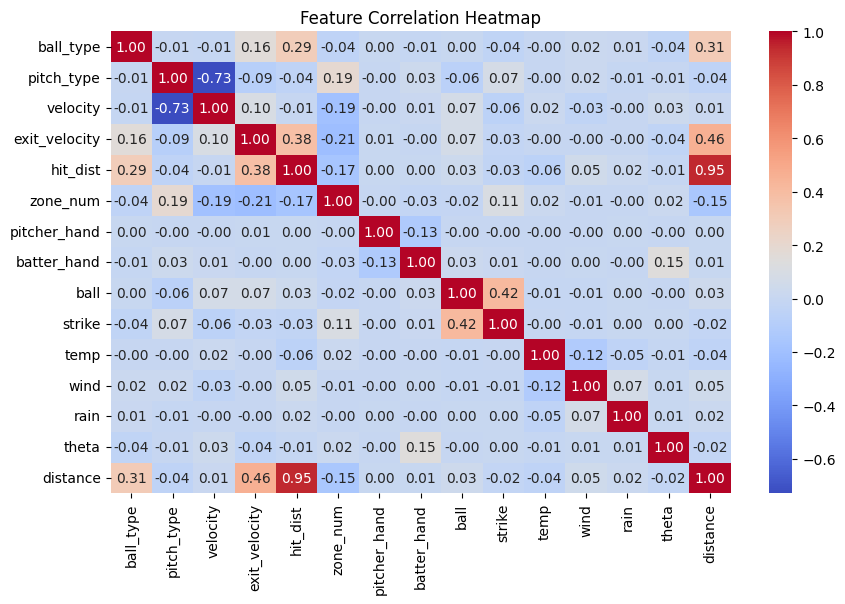

In [ ]:
corr_matrix = df.corr()

# 히트맵 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# theta와 독립 변수들 간의 상관관계
theta_corr = df.corr()['theta_p'].drop(['theta_p', "theta_n", 'distance'])
print("Theta와 독립 변수 간의 상관관계:\n", theta_corr.sort_values(ascending=False))

# distance와 독립 변수들 간의 상관관계
distance_corr = df.corr()['distance'].drop(['theta_p', "theta_n", 'distance'])
print("\nDistance와 독립 변수 간의 상관관계:\n", distance_corr.sort_values(ascending=False))


Theta와 독립 변수 간의 상관관계:
 player_age        0.027306
ball_type         0.017171
isolated_power    0.011054
pitch_type        0.007988
place             0.007962
slg_percent       0.007304
pitcher_hand      0.004069
babip            -0.000654
ball             -0.002661
temp             -0.005399
strike           -0.010458
rain             -0.010557
wind             -0.012596
zone_num         -0.018380
id               -0.026082
velocity         -0.035185
exit_velocity    -0.049372
hit_dist         -0.055099
batter_hand      -0.147847
Name: theta_p, dtype: float64

Distance와 독립 변수 간의 상관관계:
 hit_dist          0.946130
exit_velocity     0.462828
ball_type         0.310793
isolated_power    0.063352
slg_percent       0.047271
ball              0.033306
wind              0.026653
place             0.020342
rain              0.019450
player_age        0.012785
velocity          0.009323
batter_hand       0.005599
pitcher_hand      0.001295
babip            -0.002962
id               -0.009915
st

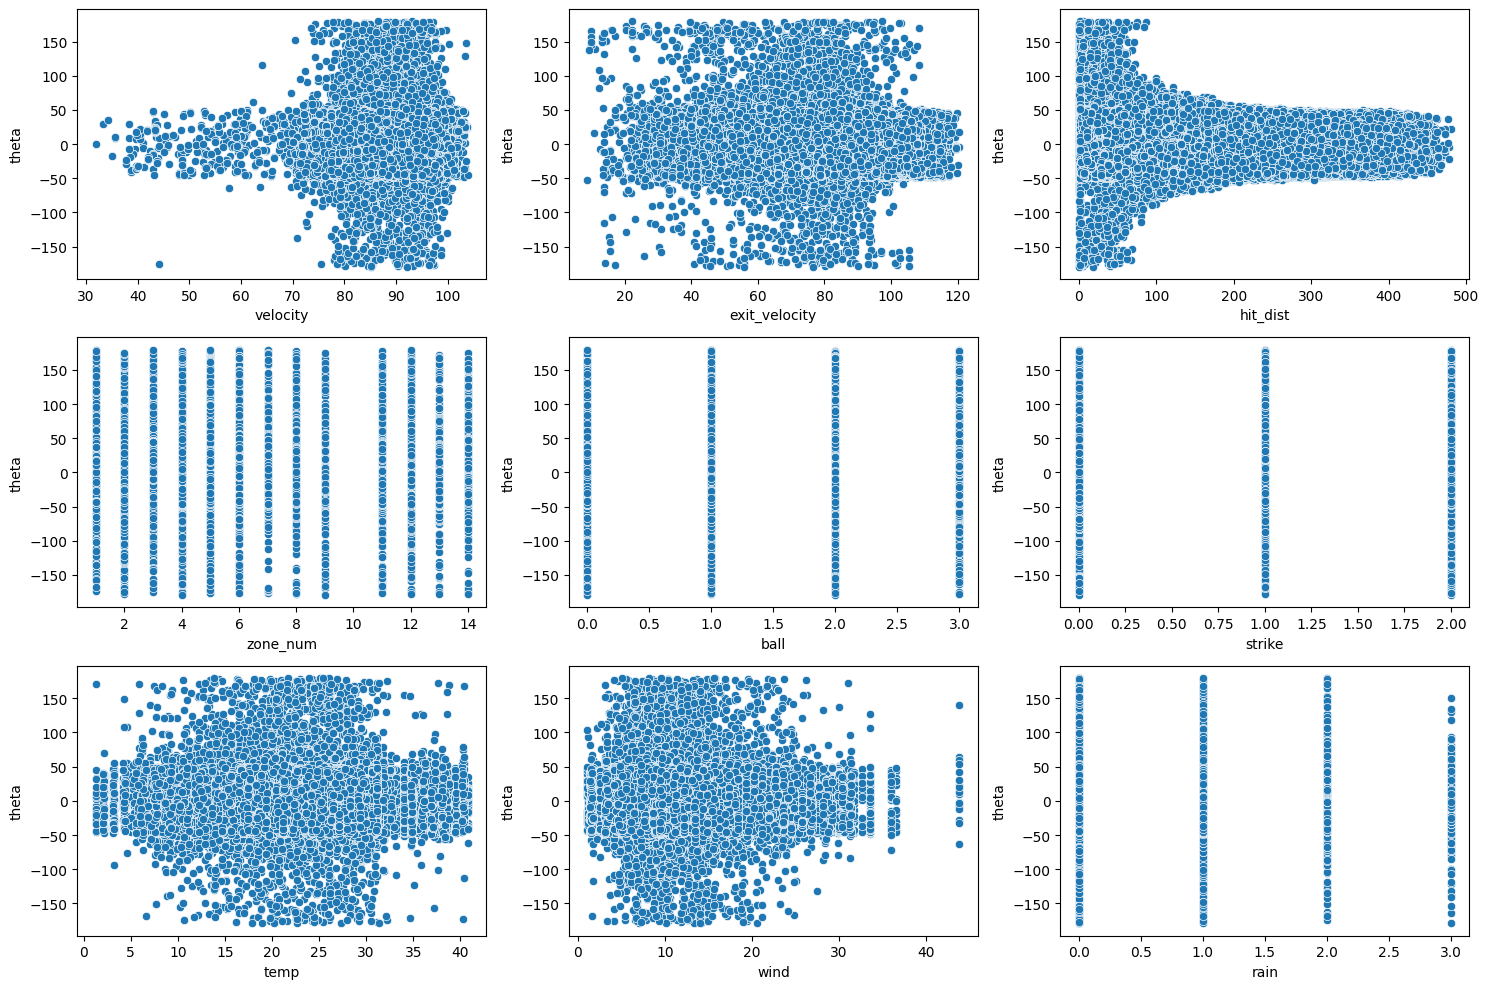

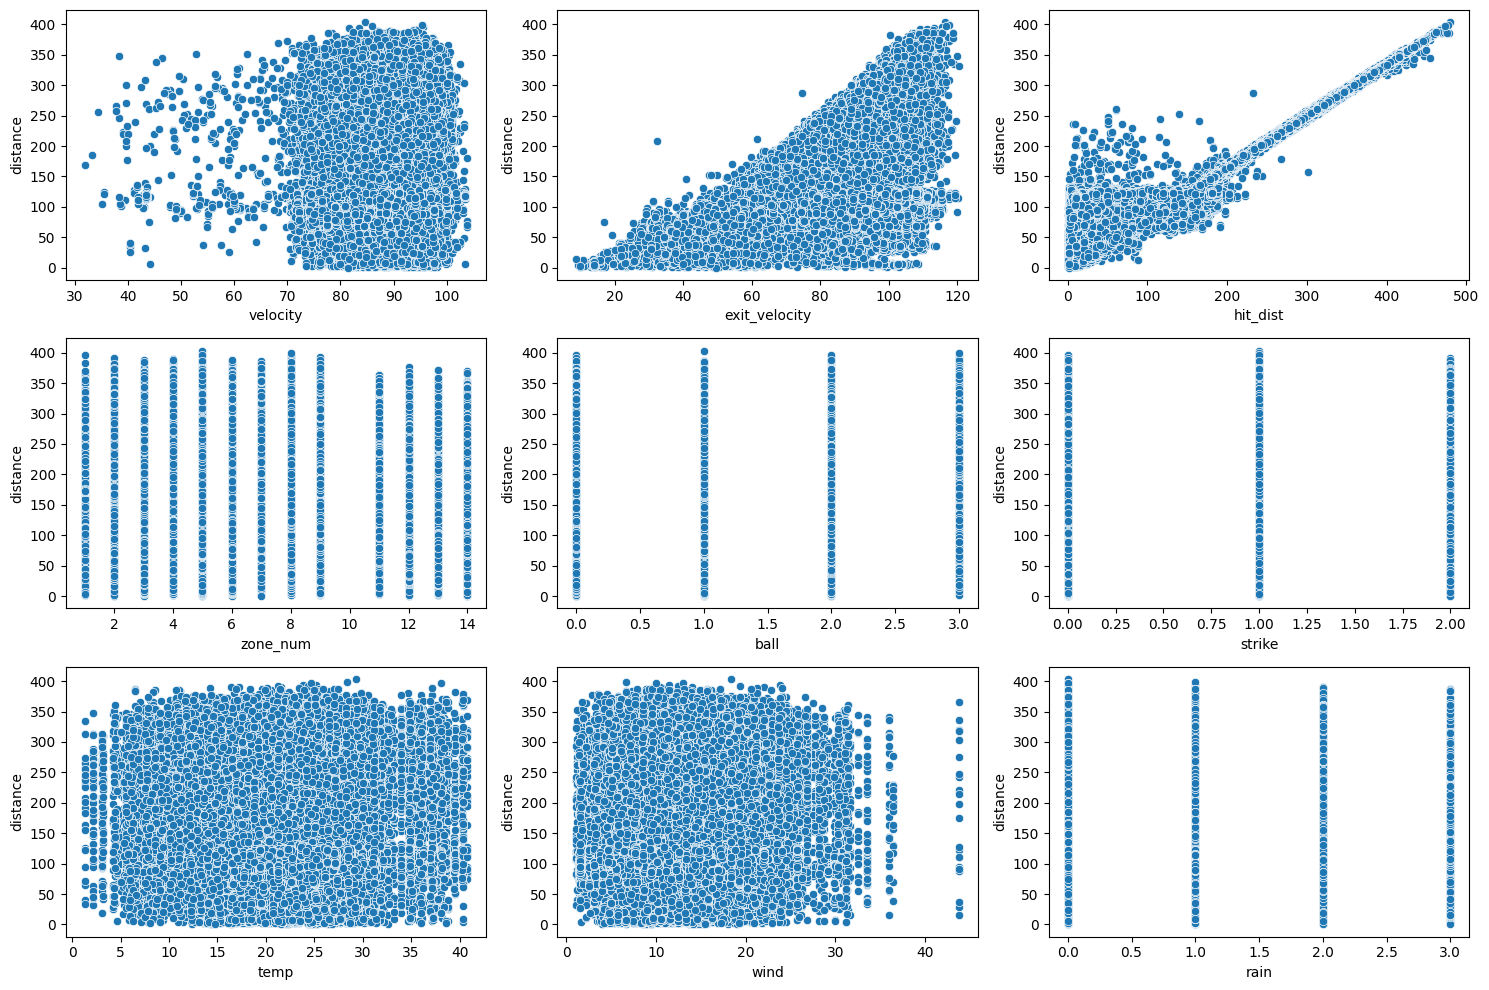

In [ ]:
# 독립 변수 리스트 (숫자형 변수만 사용)
independent_vars = ['velocity', 'exit_velocity', 'hit_dist', 'zone_num', 'ball', 'strike', 'temp', 'wind', 'rain']

# theta와의 관계
plt.figure(figsize=(15, 10))
for i, col in enumerate(independent_vars):
    plt.subplot(3, 3, i+1)
    sns.scatterplot(x=df[col], y=df['theta'])
    plt.xlabel(col)
    plt.ylabel("theta")
plt.tight_layout()
plt.show()

# distance와의 관계
plt.figure(figsize=(15, 10))
for i, col in enumerate(independent_vars):
    plt.subplot(3, 3, i+1)
    sns.scatterplot(x=df[col], y=df['distance'])
    plt.xlabel(col)
    plt.ylabel("distance")
plt.tight_layout()
plt.show()


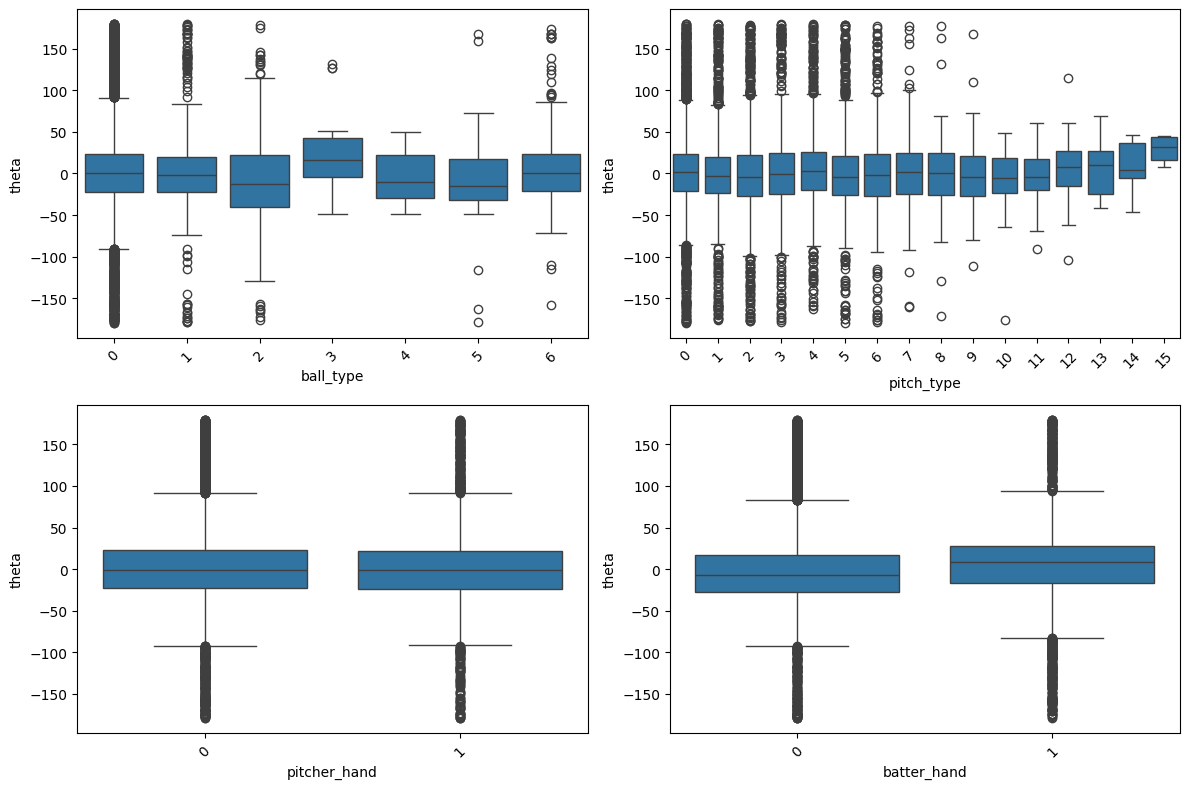

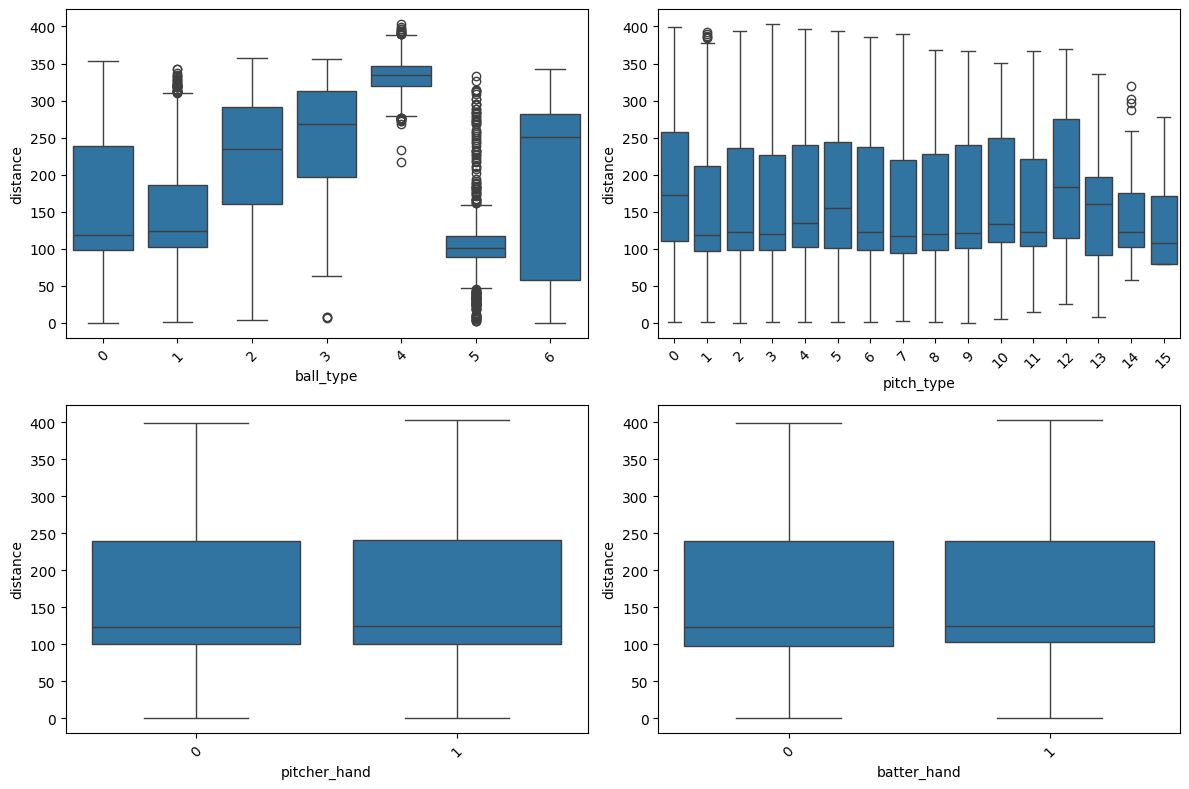

In [ ]:
categorical_vars = ['ball_type', 'pitch_type', 'pitcher_hand', 'batter_hand']

plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_vars):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=df[col], y=df['theta'])
    plt.xlabel(col)
    plt.ylabel("theta")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_vars):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x=df[col], y=df['distance'])
    plt.xlabel(col)
    plt.ylabel("distance")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# 타겟 변수만 추출
target_vars = df[['theta', 'distance']]

# PCA 적용 (1개의 주성분)
pca = PCA(n_components=1)
df['pca_target'] = pca.fit_transform(target_vars)

# PCA 변환된 타겟 변수와 독립 변수 간의 상관관계
corr_pca = df.corr()['pca_target'].drop(['theta', 'distance', 'pca_target'])

# 상관관계 출력
print("PCA Target과 독립 변수 간의 상관관계:\n", corr_pca.sort_values(ascending=False))


PCA Target과 독립 변수 간의 상관관계:
 hit_dist         0.945909
exit_velocity    0.462595
ball_type        0.305802
wind             0.045438
ball             0.034178
rain             0.018767
velocity         0.007268
batter_hand      0.004979
pitcher_hand     0.001636
strike          -0.022221
pitch_type      -0.044555
temp            -0.044570
zone_num        -0.155044
Name: pca_target, dtype: float64


Exit Velocity와 Velocity의 상관계수: 0.1003


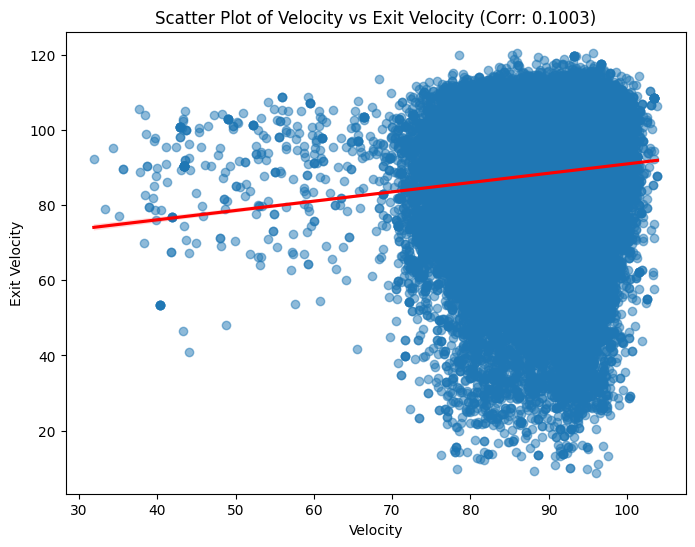

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# exit_velocity와 velocity의 상관계수 계산
corr_value = df[['exit_velocity', 'velocity']].corr().iloc[0, 1]
print(f"Exit Velocity와 Velocity의 상관계수: {corr_value:.4f}")

# 산점도와 회귀선 시각화
plt.figure(figsize=(8, 6))
sns.regplot(x=df['velocity'], y=df['exit_velocity'], scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel("Velocity")
plt.ylabel("Exit Velocity")
plt.title(f"Scatter Plot of Velocity vs Exit Velocity (Corr: {corr_value:.4f})")
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

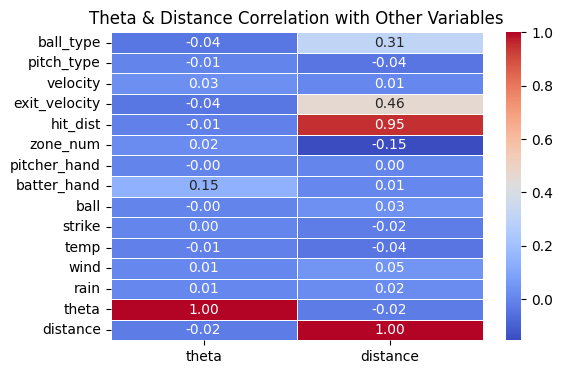

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr()[["theta", "distance"]], annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Theta & Distance Correlation with Other Variables")
plt.show()

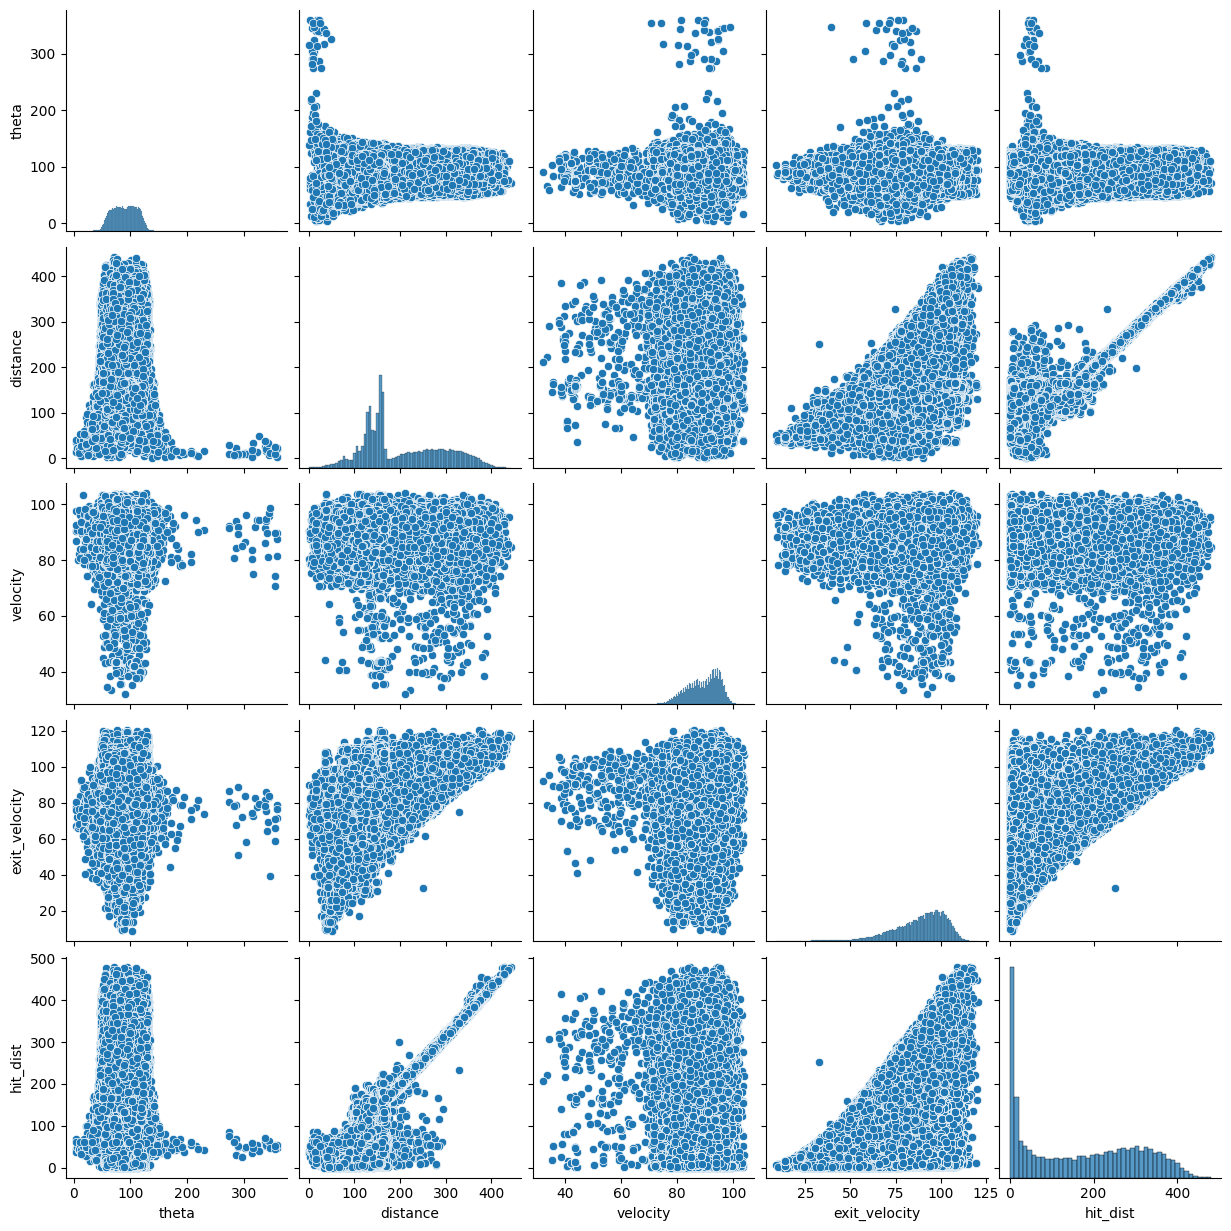

In [ ]:
sns.pairplot(df, vars=["theta", "distance", "velocity", "exit_velocity", "hit_dist"])
plt.show()
